## Trade History Model

This notebook implements the model to predict the yield spread from the sequence of trades

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from google.cloud import bigquery
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
# from keras.backend import cast
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMRegressor
import lightgbm

from IPython.display import display, HTML
import os

import wandb
from wandb.keras import WandbCallback


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS,TRADE_HISTORY

Extension horovod.torch has not been built: /opt/conda/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Setting the seed for layer initializer. We want the layers to be initialized with the same values to make the experiments deterministic

In [2]:
layer_initializer = initializers.RandomNormal(mean=0.0, stddev=0.1, seed=10)

In [3]:
pd.options.mode.chained_assignment = None

Setting the environment variables

In [4]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/shayaan/ficc/ml_models/sequence_predictors/eng-reactor-287421-112eb767e1b3.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Initializing BigQuery client

In [5]:
bq_client = bigquery.Client()

Declaring hyper-parameters

In [6]:
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.0001
BATCH_SIZE = 1000
NUM_EPOCHS = 100

DROPOUT = 0.01
SEQUENCE_LENGTH = 5
NUM_FEATURES = 5

#### Initializing Wandb

In [7]:
# wandb.init(project="yield_spread_model", entity="ficc-ai", name="trade_history_customer_sold_purchase_removing_calc_date")

#### Query to fetch data

We create the training data from the trades which occured between July and October in 2021. All three trade directions, namely dealer-dealer (D), dealer-sells (S), and dealer-purchases (P) are included. We are limiting the training to bonds whose yield is a positive number less than three.

In [8]:
DATA_QUERY = """
SELECT
  *
FROM
  `eng-reactor-287421.auxiliary_views.materialized_trade_history`
WHERE
  yield IS NOT NULL
  AND yield > 0 
  AND yield <= 3 
  AND par_traded IS NOT NULL
  AND trade_date >= '2021-07-01' 
  AND trade_date <= '2021-12-31'
  AND maturity_description_code = 2
  AND incorporated_state_code <> 'US'
  AND coupon_type = 8
  AND trade_type = 'D'
  AND msrb_valid_to_date > current_date -- condition to remove cancelled trades
ORDER BY
  trade_date DESC
            """

#### Data Preparation
We grab the data from BigQuery and converts it into a format suitable for input to the model. We save the processed data as a pickle file. If the file already exists we read it from the file. 

In [9]:
processed_file = 'temp_test_MMD.pkl'

In [10]:
%%time
if not os.path.isfile(processed_file):
    data = process_data(DATA_QUERY, 
                        bq_client,
                        SEQUENCE_LENGTH,
                        NUM_FEATURES,
                        'raw_data_temp.pkl',
                        'FICC',
                        estimate_calc_date=True,
                        remove_short_maturity=True,
                        remove_non_transaction_based=False,
                       remove_trade_type = [])
    data.to_pickle(processed_file)
else:
    print('Reading from processed file')
    data = pd.read_pickle(processed_file)

Reading from processed file
CPU times: user 3.35 s, sys: 996 ms, total: 4.34 s
Wall time: 4.34 s


In [11]:
# data=data[data.is_non_transaction_based_compensation != True]

In [12]:
training_data = data[IDENTIFIERS + TRADE_HISTORY + ['days_to_maturity','yield_spread','dollar_price','last_yield_spread','last_seconds_ago','trade_date','trade_type','calc_date','yield','purpose_class','purpose_sub_class']]

In [13]:
# training_data = training_data[training_data.days_to_maturity > np.log10(360)]

In [14]:
training_data['days_to_calc'] = (training_data.calc_date - training_data.trade_date).dt.days

In [15]:
training_data = training_data[training_data.days_to_calc > 400]

In [16]:
training_data['delta_last_yield_spread'] = np.abs(training_data['yield_spread'] - training_data['last_yield_spread'])

In [18]:
len(training_data)

531824

In [19]:
# training_data = training_data[training_data.delta_last_yield_spread < 10]

In [20]:
training_data = training_data[training_data.trade_type.isin(['D'])]

In [21]:
len(training_data)

531824

In [22]:
len(np.unique(training_data.cusip))

108501

### Splitting the data into train and test sets


In [23]:
train_index = int(len(training_data) * (1-TRAIN_TEST_SPLIT))
train_dataframe = training_data[train_index:]
test_dataframe = training_data[:train_index]
print(f'Print length of training data frame {len(train_dataframe)}')
print(f'Pring length of testing data frame {len(test_dataframe)}')

Print length of training data frame 452051
Pring length of testing data frame 79773


In [24]:
test_dataframe

,rtrs_control_number,cusip,trade_history,days_to_maturity,yield_spread,dollar_price,last_yield_spread,last_seconds_ago,trade_date,trade_type,calc_date,yield,purpose_class,purpose_sub_class,days_to_calc,delta_last_yield_spread
0,2021123100037900,215111BE4,"[[62.20356390200624, 4.397940158843994, 1.0, 0...",3.253580,49.062529,113.890,62.203564,4.855949,2021-12-31,D,2026-12-01,1.086,37.0,34.0,1796,13.141035
1,2021123101057500,250375GV8,"[[29.853263547640807, 4.0, 1.0, 0.0, 5.5415180...",3.308778,17.907804,122.671,29.853264,5.541518,2021-12-31,D,2027-08-01,0.830,9.0,16.0,2039,11.945460
3,2021123100886600,29270CV85,"[[3.2559877383318536, 6.414973258972168, 0.0, ...",3.105510,41.889828,114.105,3.255988,6.425801,2021-12-31,D,2025-07-01,0.888,50.0,28.0,1278,38.633840
4,2021123101116400,57584XYG0,"[[54.506377550811635, 4.397940158843994, 0.0, ...",3.724849,63.863729,139.940,54.506378,6.700855,2021-12-31,D,2036-07-15,1.852,9.0,122.0,5310,9.357352
5,2021123101289700,67759HLZ5,"[[18.05681839448379, 4.903090000152588, 0.0, 0...",3.357935,41.454508,123.335,18.056818,7.123968,2021-12-31,D,2028-04-01,1.119,3.0,53.0,2283,23.397689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116987,2021120600886700,20772JWP3,"[[70.38263722707552, 4.397940158843994, 0.0, 0...",3.593397,64.511837,107.950,70.382637,6.480149,2021-12-06,D,2024-09-01,1.039,51.0,NaN,1000,5.870800
116988,2021120604955500,006797BR4,"[[38.174315263278615, 4.397940158843994, 0.0, ...",3.307924,26.278196,122.129,38.174315,6.353206,2021-12-06,D,2027-07-01,0.912,50.0,129.0,2033,11.896119
116989,2021120606189900,033162CV8,"[[119.03065916557958, 4.397940158843994, 0.0, ...",3.314499,122.480434,95.760,119.030659,6.170598,2021-12-06,D,2027-08-01,1.881,51.0,NaN,2064,3.449775
116991,2021120601898500,101029XD3,"[[90.05202285408448, 6.301030158996582, 1.0, 0...",3.558228,73.745697,101.178,90.052023,5.404811,2021-12-06,D,2031-11-01,1.699,50.0,129.0,3617,16.306326


In [25]:
%%time
x_train = np.stack(train_dataframe.trade_history.to_numpy())
y_train = train_dataframe.yield_spread.to_numpy()


CPU times: user 1 s, sys: 7.52 ms, total: 1.01 s
Wall time: 1.01 s


In [26]:
%%time
x_test = np.stack(test_dataframe.trade_history.to_numpy())
y_test =  test_dataframe.yield_spread.to_numpy()

CPU times: user 189 ms, sys: 177 µs, total: 190 ms
Wall time: 189 ms


In [27]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(452051, 5, 5)
(452051,)
(79773, 5, 5)


#### Implementation of the model

In [28]:
inputs = []
layer = []

############## INPUT BLOCK ###################
trade_history_input = layers.Input(name="trade_history_input", 
                                   shape=(SEQUENCE_LENGTH,NUM_FEATURES), 
                                   dtype = tf.float32) 

inputs.append(trade_history_input)

####################################################


############## TRADE HISTORY MODEL #################

# Adding the time2vec encoding to the input to transformer
lstm_layer = layers.LSTM(50, 
                         activation='tanh',
                         input_shape=(SEQUENCE_LENGTH,NUM_FEATURES),
                         kernel_initializer = layer_initializer,
                         return_sequences = True,
                         name='LSTM')

lstm_layer_2 = layers.LSTM(100, 
                           activation='tanh',
                           input_shape=(SEQUENCE_LENGTH,50),
                           kernel_initializer = layer_initializer,
                           return_sequences = False,
                           name='LSTM_2')

features = lstm_layer(inputs[0])
features = layers.BatchNormalization()(features)
features = layers.Dropout(0.1)(features)

features = lstm_layer_2(features)
features = layers.Dropout(0.1)(features)
features = layers.BatchNormalization()(features)

trade_history_output = layers.Dense(100, 
                                    activation='relu',
                                    kernel_initializer=layer_initializer)(features)

hidden = layers.Dense(300,
                      activation='relu',
                      kernel_initializer=layer_initializer)(trade_history_output)
hidden = layers.BatchNormalization()(hidden)
hidden = layers.Dropout(DROPOUT)(hidden)

hidden2 = layers.Dense(100,
                       activation='tanh',
                       kernel_initializer=layer_initializer)(hidden)
hidden2 = layers.BatchNormalization()(hidden2)
hidden2 = layers.Dropout(DROPOUT)(hidden2)

final = layers.Dense(1,
                     kernel_initializer=layer_initializer)(hidden2)

model = keras.Model(inputs=inputs, outputs=final)

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 trade_history_input (InputL  [(None, 5, 5)]           0         
 ayer)                                                           
                                                                 
 LSTM (LSTM)                 (None, 5, 50)             11200     
                                                                 
 batch_normalization (BatchN  (None, 5, 50)            200       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 LSTM_2 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0     

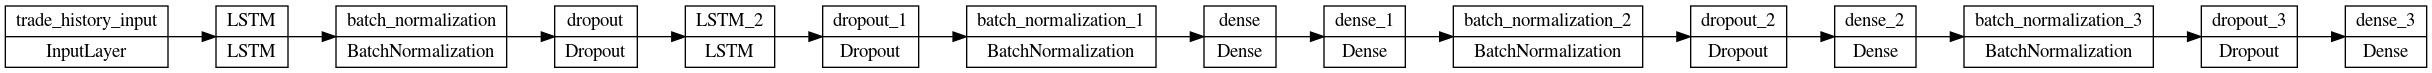

In [30]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

In [31]:
fit_callbacks = [
#     WandbCallback(),
#     keras.callbacks.EarlyStopping(
#         monitor="val_loss",
#         patience=10,
#         verbose=0,
#         mode="auto",
#         restore_best_weights=True,
#     )
]

In [32]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanSquaredError(),
          metrics=[keras.metrics.MeanAbsoluteError()])

In [33]:
%time history = model.fit(x_train,y_train,epochs=200,batch_size=BATCH_SIZE,verbose=1,validation_split=0.1,callbacks=fit_callbacks)

Epoch 1/200
407/407 [==============================] - 9s 10ms/step - loss: 4164.0659 - mean_absolute_error: 54.3856 - val_loss: 4309.1831 - val_mean_absolute_error: 57.8622
Epoch 2/200
407/407 [==============================] - 3s 8ms/step - loss: 3706.1692 - mean_absolute_error: 53.5279 - val_loss: 3888.6267 - val_mean_absolute_error: 56.8272
Epoch 3/200
407/407 [==============================] - 3s 8ms/step - loss: 3324.9504 - mean_absolute_error: 52.2454 - val_loss: 3290.3479 - val_mean_absolute_error: 53.3367
Epoch 4/200
407/407 [==============================] - 3s 8ms/step - loss: 2974.7896 - mean_absolute_error: 50.5815 - val_loss: 2739.9421 - val_mean_absolute_error: 49.1975
Epoch 5/200
407/407 [==============================] - 3s 8ms/step - loss: 2664.5706 - mean_absolute_error: 48.6275 - val_loss: 2290.6021 - val_mean_absolute_error: 45.3963
Epoch 6/200
407/407 [==============================] - 3s 8ms/step - loss: 2396.4131 - mean_absolute_error: 46.4680 - val_loss: 2027.7

Epoch 49/200
407/407 [==============================] - 3s 8ms/step - loss: 199.9869 - mean_absolute_error: 9.7131 - val_loss: 204.8807 - val_mean_absolute_error: 9.4897
Epoch 50/200
407/407 [==============================] - 3s 8ms/step - loss: 199.6510 - mean_absolute_error: 9.6994 - val_loss: 199.9685 - val_mean_absolute_error: 9.5608
Epoch 51/200
407/407 [==============================] - 3s 8ms/step - loss: 200.1396 - mean_absolute_error: 9.6952 - val_loss: 202.1578 - val_mean_absolute_error: 9.5603
Epoch 52/200
407/407 [==============================] - 3s 8ms/step - loss: 199.5856 - mean_absolute_error: 9.6926 - val_loss: 205.9542 - val_mean_absolute_error: 9.7024
Epoch 53/200
407/407 [==============================] - 3s 8ms/step - loss: 198.8167 - mean_absolute_error: 9.6842 - val_loss: 210.8706 - val_mean_absolute_error: 9.8842
Epoch 54/200
407/407 [==============================] - 3s 8ms/step - loss: 198.4870 - mean_absolute_error: 9.6814 - val_loss: 195.8949 - val_mean_abs

Epoch 145/200
407/407 [==============================] - 3s 8ms/step - loss: 186.7353 - mean_absolute_error: 9.3665 - val_loss: 199.3743 - val_mean_absolute_error: 9.4659
Epoch 146/200
407/407 [==============================] - 3s 8ms/step - loss: 186.3562 - mean_absolute_error: 9.3667 - val_loss: 202.8464 - val_mean_absolute_error: 9.6933
Epoch 147/200
407/407 [==============================] - 3s 8ms/step - loss: 186.3324 - mean_absolute_error: 9.3693 - val_loss: 225.9737 - val_mean_absolute_error: 10.0795
Epoch 148/200
407/407 [==============================] - 3s 8ms/step - loss: 186.9753 - mean_absolute_error: 9.3748 - val_loss: 203.4455 - val_mean_absolute_error: 9.4919
Epoch 149/200
407/407 [==============================] - 3s 8ms/step - loss: 185.5823 - mean_absolute_error: 9.3519 - val_loss: 206.4262 - val_mean_absolute_error: 9.7496
Epoch 150/200
407/407 [==============================] - 3s 8ms/step - loss: 187.0150 - mean_absolute_error: 9.3715 - val_loss: 194.0782 - val_m

Epoch 193/200
407/407 [==============================] - 3s 8ms/step - loss: 183.1285 - mean_absolute_error: 9.2955 - val_loss: 212.1467 - val_mean_absolute_error: 9.6430
Epoch 194/200
407/407 [==============================] - 3s 8ms/step - loss: 182.5088 - mean_absolute_error: 9.2788 - val_loss: 207.1655 - val_mean_absolute_error: 9.7038
Epoch 195/200
407/407 [==============================] - 3s 8ms/step - loss: 181.7614 - mean_absolute_error: 9.2684 - val_loss: 196.8119 - val_mean_absolute_error: 9.3394
Epoch 196/200
407/407 [==============================] - 3s 8ms/step - loss: 182.4948 - mean_absolute_error: 9.2753 - val_loss: 207.3988 - val_mean_absolute_error: 9.7552
Epoch 197/200
407/407 [==============================] - 3s 8ms/step - loss: 182.7208 - mean_absolute_error: 9.2870 - val_loss: 201.3866 - val_mean_absolute_error: 9.4245
Epoch 198/200
407/407 [==============================] - 3s 7ms/step - loss: 182.5897 - mean_absolute_error: 9.2920 - val_loss: 214.5907 - val_me

In [34]:
_, mae = model.evaluate(x_test, y_test, verbose=1)
print(f"Test MAE: {round(mae, 3)}")
# wandb.log({"Test MAE": mae})

2493/2493 [==============================] - 6s 3ms/step - loss: 234.3286 - mean_absolute_error: 10.2390
Test MAE: 10.239


#### Plotting validation loss vs training loss

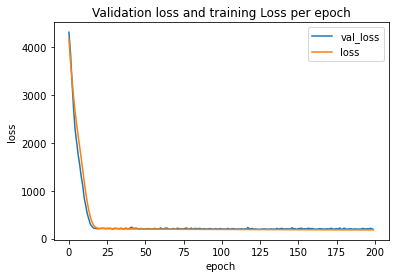

In [35]:
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.title('Validation loss and training Loss per epoch')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Analyzing the test set

In [36]:
test_preds = model.predict(x_test)

In [37]:
evaluation_dataframe = test_dataframe.copy()
evaluation_dataframe['predicted_yield_spreads'] = test_preds
evaluation_dataframe['delta_yield_spreads'] = evaluation_dataframe.yield_spread - evaluation_dataframe.predicted_yield_spreads

In [38]:
evaluation_dataframe.days_to_maturity = 10**evaluation_dataframe.days_to_maturity
# evaluation_dataframe.days_to_call = 10**evaluation_dataframe.days_to_call
# evaluation_dataframe.quantity = 10**evaluation_dataframe.quantity
evaluation_dataframe.sort_values('delta_yield_spreads', ascending=False)

,rtrs_control_number,cusip,trade_history,days_to_maturity,yield_spread,dollar_price,last_yield_spread,last_seconds_ago,trade_date,trade_type,calc_date,yield,purpose_class,purpose_sub_class,days_to_calc,delta_last_yield_spread,predicted_yield_spreads,delta_yield_spreads
100436,2021120805567500,646139Y74,"[[-57.34664806490806, 4.544067859649658, 0.0, ...",4041.0,143.255462,100.144,-57.346648,5.787148,2021-12-08,D,2033-01-01,2.473,48.0,121.0,4042,200.602110,-61.113899,204.369362
112431,2021120603880500,880461ES3,"[[255.715389452686, 4.397940158843994, 1.0, 0....",8426.0,260.194429,102.501,255.715389,7.792068,2021-12-06,D,2024-07-01,2.979,18.0,106.0,938,4.479040,57.460247,202.734182
105154,2021120701425600,246352GF9,"[[35.33894199360217, 5.301030158996582, 0.0, 1...",6599.0,240.651704,104.500,35.338942,4.811582,2021-12-07,D,2024-01-01,2.742,48.0,79.0,755,205.312762,44.141254,196.510450
47248,2021122004578800,60416SSZ4,"[[146.31279883547646, 4.397940158843994, 0.0, ...",1837.0,241.573359,101.027,146.312799,7.788971,2021-12-20,D,2026-01-01,2.928,18.0,106.0,1473,95.260560,55.116600,186.456759
52442,2021121702176300,166393Z76,"[[61.3648894394107, 4.477121353149414, 0.0, 1....",2934.0,212.326135,100.000,61.364889,7.827508,2021-12-17,D,2030-01-01,2.958,19.0,NaN,2937,150.961246,38.194279,174.131857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32803,2021122203480400,650009ZB2,"[[3597.6933744513854, 4.0, 0.0, 0.0, 3.9197055...",7311.0,-121.006626,100.053,3597.693374,3.919706,2021-12-22,D,2042-01-01,0.224,48.0,10.0,7315,3718.700000,39.458023,-160.464649
108149,2021120705709600,684515QB8,"[[411.8807385488836, 4.0, 1.0, 0.0, 4.31130874...",2581.0,14.480739,100.248,411.880739,4.311309,2021-12-07,D,2029-01-01,0.919,46.0,32.0,2582,397.400000,215.327194,-200.846456
68250,2021121503770000,650009ZB2,"[[408.60609106153305, 4.698969841003418, 0.0, ...",7321.0,-16.493909,100.144,408.606091,3.826140,2021-12-15,D,2042-01-01,1.266,48.0,10.0,7322,425.100000,191.064011,-207.557920
96260,2021120902912500,646139Y66,"[[5.039514521508991, 5.0, 0.0, 0.0, 4.89609611...",4772.0,-96.302735,100.294,5.039515,4.896096,2021-12-09,D,2035-01-01,0.184,48.0,121.0,4771,101.342249,137.003525,-233.306260


#### Isolating trades with error greater than 50 bps

In [39]:
# list(temp[temp.rtrs_control_number == 2021100102344900]['trade_history'])

In [40]:
temp = evaluation_dataframe[(evaluation_dataframe.delta_yield_spreads > 50) | (evaluation_dataframe.delta_yield_spreads < -50)  ]
temp = temp.sort_values('delta_yield_spreads',ascending=False)
display(temp)
temp.to_csv('greater_than_50.csv',index=False)

,rtrs_control_number,cusip,trade_history,days_to_maturity,yield_spread,dollar_price,last_yield_spread,last_seconds_ago,trade_date,trade_type,calc_date,yield,purpose_class,purpose_sub_class,days_to_calc,delta_last_yield_spread,predicted_yield_spreads,delta_yield_spreads
100436,2021120805567500,646139Y74,"[[-57.34664806490806, 4.544067859649658, 0.0, ...",4041.0,143.255462,100.144,-57.346648,5.787148,2021-12-08,D,2033-01-01,2.473,48.0,121.0,4042,200.602110,-61.113899,204.369362
112431,2021120603880500,880461ES3,"[[255.715389452686, 4.397940158843994, 1.0, 0....",8426.0,260.194429,102.501,255.715389,7.792068,2021-12-06,D,2024-07-01,2.979,18.0,106.0,938,4.479040,57.460247,202.734182
105154,2021120701425600,246352GF9,"[[35.33894199360217, 5.301030158996582, 0.0, 1...",6599.0,240.651704,104.500,35.338942,4.811582,2021-12-07,D,2024-01-01,2.742,48.0,79.0,755,205.312762,44.141254,196.510450
47248,2021122004578800,60416SSZ4,"[[146.31279883547646, 4.397940158843994, 0.0, ...",1837.0,241.573359,101.027,146.312799,7.788971,2021-12-20,D,2026-01-01,2.928,18.0,106.0,1473,95.260560,55.116600,186.456759
52442,2021121702176300,166393Z76,"[[61.3648894394107, 4.477121353149414, 0.0, 1....",2934.0,212.326135,100.000,61.364889,7.827508,2021-12-17,D,2030-01-01,2.958,19.0,NaN,2937,150.961246,38.194279,174.131857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32803,2021122203480400,650009ZB2,"[[3597.6933744513854, 4.0, 0.0, 0.0, 3.9197055...",7311.0,-121.006626,100.053,3597.693374,3.919706,2021-12-22,D,2042-01-01,0.224,48.0,10.0,7315,3718.700000,39.458023,-160.464649
108149,2021120705709600,684515QB8,"[[411.8807385488836, 4.0, 1.0, 0.0, 4.31130874...",2581.0,14.480739,100.248,411.880739,4.311309,2021-12-07,D,2029-01-01,0.919,46.0,32.0,2582,397.400000,215.327194,-200.846456
68250,2021121503770000,650009ZB2,"[[408.60609106153305, 4.698969841003418, 0.0, ...",7321.0,-16.493909,100.144,408.606091,3.826140,2021-12-15,D,2042-01-01,1.266,48.0,10.0,7322,425.100000,191.064011,-207.557920
96260,2021120902912500,646139Y66,"[[5.039514521508991, 5.0, 0.0, 0.0, 4.89609611...",4772.0,-96.302735,100.294,5.039515,4.896096,2021-12-09,D,2035-01-01,0.184,48.0,121.0,4771,101.342249,137.003525,-233.306260


In [41]:
temp['delta_last_yield_spread'] = temp.yield_spread - temp.last_yield_spread

In [42]:
temp = temp.sort_values('delta_last_yield_spread',ascending=False)
# temp = temp[temp.dollar_price > 103]
temp_rtrs_control_number = list(temp.rtrs_control_number)

In [43]:
raw_data = pd.read_pickle('raw_data_temp.pkl')

In [44]:
temp['un_processed_hist'] = raw_data[raw_data.rtrs_control_number.isin(temp_rtrs_control_number)]['recent']

In [45]:
len(np.unique(test_dataframe.cusip))

36014

In [46]:
len(np.unique(temp.cusip))

707

In [47]:
temp.iloc[-3]['un_processed_hist'][0]

{'rtrs_control_number': 2021121501892600.0,
 'trade_datetime': datetime.datetime(2021, 12, 15, 11, 22, 4),
 'publish_datetime': datetime.datetime(2021, 12, 15, 11, 25, 17),
 'msrb_valid_from_date': datetime.datetime(2021, 12, 15, 11, 25, 17),
 'msrb_valid_to_date': datetime.datetime(2100, 1, 1, 0, 0),
 'yield_spread': 6.26921387455872,
 'yield': 7.408,
 'dollar_price': 99.9,
 'par_traded': Decimal('10000.000000000'),
 'trade_type': 'D',
 'seconds_ago': 2016.0,
 'is_non_transaction_based_compensation': False,
 'is_lop_or_takedown': False,
 'brokers_broker': None,
 'is_alternative_trading_system': False,
 'is_weighted_average_price': False,
 'settlement_date': datetime.date(2021, 12, 17)}

In [48]:
temp.un_processed_hist = temp.un_processed_hist.apply(lambda x: x[:SEQUENCE_LENGTH])

In [49]:
temp.to_csv('dealer_investgation.csv',index=False)

In [50]:
temp.purpose_class.value_counts()

18.0    140
50.0    109
46.0    103
37.0     97
51.0     95
48.0     93
9.0      64
19.0     46
17.0     45
15.0     26
25.0     25
3.0      24
1.0      19
8.0      14
34.0     10
38.0      8
27.0      6
24.0      5
21.0      5
6.0       4
20.0      3
28.0      3
10.0      3
30.0      2
52.0      2
39.0      2
33.0      2
29.0      1
13.0      1
11.0      1
Name: purpose_class, dtype: int64

In [51]:
temp.trade_type.value_counts()

D    958
Name: trade_type, dtype: int64

In [51]:
data[data.rtrs_control_number.isin(temp_rtrs_control_number)]

,MSRB_maturity_date,msrb_cusip,yield_spread,my_price,price_delta,num_prev_messages,MSRB_INST_ORDR_DESC,MSRB_valid_from_date,MSRB_valid_to_date,trade_datetime,...,days_to_maturity,days_to_call,days_to_refund,days_to_par,call_to_maturity,last_seconds_ago,last_yield_spread,last_size,accrued_days,days_in_interest_payment
125,2026-01-01,77735AAF4,137.477945,98.377,0.000,0,1,2021-12-31 11:57:16,2100-01-01,2021-12-31 11:56:25,...,3.164055,0.000000,0.000000,0.000000,0.000000,7.303534,131.912799,4.176091,448,180.0
281,2036-08-01,678505FX1,188.138221,106.359,0.001,0,1,2021-12-31 11:55:15,2100-01-01,2021-12-31 11:54:41,...,3.726238,3.222976,0.000000,3.222976,3.562769,7.645859,127.289767,4.778151,2018,180.0
467,2029-12-15,046578AL4,204.345644,115.000,0.000,0,1,2021-12-31 10:55:00,2100-01-01,2021-12-31 10:54:44,...,3.462847,0.000000,0.000000,0.000000,0.000000,6.162663,116.394286,4.845098,556,180.0
498,2038-11-15,59259YD22,76.344834,105.374,0.001,0,1,2021-12-31 12:02:02,2100-01-01,2021-12-31 12:00:29,...,3.789581,2.696356,0.000000,2.696356,3.753123,4.958215,130.626865,4.397940,3083,180.0
621,2025-04-01,76221RJ53,144.423961,97.840,0.001,0,1,2021-12-31 11:58:15,2100-01-01,2021-12-31 11:57:48,...,3.073352,0.000000,0.000000,0.000000,0.000000,7.112152,83.938390,4.477121,433,180.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114848,2031-01-01,299488CJ3,18.987659,100.192,0.000,0,1,2021-12-06 13:34:32,2100-01-01,2021-12-06 13:33:24,...,3.520090,0.000000,1.397940,0.000000,0.000000,6.550261,-25.711760,4.000000,2932,180.0
115929,2027-11-15,20775HEF6,17.022773,99.422,0.000,0,1,2021-12-06 12:03:50,2100-01-01,2021-12-06 12:02:20,...,3.336260,0.000000,0.000000,0.000000,0.000000,6.261049,57.159955,4.000000,284,180.0
116379,2042-01-01,650009ZB2,-111.437265,100.312,0.000,0,1,2021-12-06 14:03:38,2100-01-01,2021-12-06 14:02:50,...,3.865163,0.000000,1.414973,0.000000,0.000000,5.414973,-30.582962,4.176091,3386,180.0
116883,2026-05-15,249901YB9,158.017574,105.756,0.001,0,1,2021-12-06 16:36:36,2100-01-01,2021-12-06 16:34:34,...,3.209515,0.000000,0.000000,0.000000,0.000000,7.005071,66.538882,4.397940,1015,180.0


#### Isolating trades with error less than 3 bps

In [68]:
temp = evaluation_dataframe[(evaluation_dataframe.delta_yield_spreads < 3) & (evaluation_dataframe.delta_yield_spreads > -3)  ]
temp.sort_values('delta_yield_spreads',ascending=False)
display(temp)
temp.to_csv('less_than_3.csv',index=False)

,rtrs_control_number,cusip,trade_history,days_to_maturity,yield_spread,dollar_price,last_yield_spread,last_seconds_ago,trade_date,trade_type,calc_date,yield,days_to_calc,predicted_yield_spreads,delta_yield_spreads
1,2021123101057500,250375GV8,"[[29.853263547640807, 4.0, 1.0, 0.0, 5.5415180...",2036.0,17.907804,122.671,29.853264,5.541518,2021-12-31,D,2027-08-01,0.830,2039,20.274269,-2.366465
9,2021123101661400,92778VKU1,"[[39.620880165055055, 4.397940158843994, 0.0, ...",2951.0,27.320880,129.930,39.620880,3.760045,2021-12-31,D,2030-02-01,1.114,2954,29.560638,-2.239758
19,2021123101806300,579173CE3,"[[47.91908835709889, 4.602059841156006, 0.0, 1...",3101.0,50.878389,117.200,47.919088,6.084928,2021-12-31,D,2026-07-01,1.068,1643,51.277279,-0.398890
20,2021123101734400,757884AW1,"[[139.09458122920432, 5.096909999847412, 0.0, ...",10741.0,129.686700,106.526,139.094581,4.949731,2021-12-31,D,2031-06-01,2.227,3439,132.200165,-2.513465
26,2021123101203700,88213AJG1,"[[58.04029810748482, 4.0, 0.0, 0.0, 5.21508476...",2689.0,35.666080,120.896,58.040298,5.215085,2021-12-31,D,2027-05-15,0.990,1961,33.604321,2.061759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116980,2021120604363200,592030N55,"[[40.55999180786161, 4.977723598480225, 0.0, 1...",4907.0,40.797751,132.335,40.559992,6.083411,2021-12-06,D,2031-05-15,1.340,3447,41.062496,-0.264745
116981,2021120601346300,23542JRW7,"[[33.961362636363575, 6.301030158996582, 1.0, ...",5412.0,32.861363,131.495,33.961363,2.575188,2021-12-06,D,2030-10-01,1.220,3221,34.244152,-1.382789
116986,2021120604653300,582188KR8,"[[47.37034303133271, 4.0, 0.0, 0.0, 6.19233798...",2808.0,20.071402,111.734,47.370343,6.192338,2021-12-06,D,2024-08-15,0.590,983,21.897209,-1.825807
116987,2021120600886700,20772JWP3,"[[70.38263722707552, 4.397940158843994, 0.0, 0...",3921.0,64.511837,107.950,70.382637,6.480149,2021-12-06,D,2024-09-01,1.039,1000,62.890999,1.620838
